# 1. Librerias y Constantes (Setup Enviorment)

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import json

import torch
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

from torch_geometric.utils.convert import from_networkx
import torch_geometric.transforms as T
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv

import networkx as nx
from networkx.readwrite import json_graph

import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from Utils.Grafos_Utils import plot_graph, Dataset, informacion_de_vertices, distribucion_probabilidades

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH = os.path.join('Data', 'Flights')

# 2. Dataset: 
* https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv

In [4]:
flights = pd.read_csv(PATH + '/flights_clean_gruoped_mean.csv')
print(f'The shape is: {flights.shape}')
flights.isnull().sum()

The shape is: (4577, 28)


ORIGIN_AIRPORT         0
DESTINATION_AIRPORT    0
YEAR                   0
MONTH                  0
DAY                    0
DAY_OF_WEEK            0
SCHEDULED_DEPARTURE    0
DEPARTURE_TIME         0
DEPARTURE_DELAY        0
TAXI_OUT               0
WHEELS_OFF             0
SCHEDULED_TIME         0
ELAPSED_TIME           0
AIR_TIME               0
DISTANCE               0
WHEELS_ON              0
TAXI_IN                0
SCHEDULED_ARRIVAL      0
ARRIVAL_TIME           0
ARRIVAL_DELAY          0
DIVERTED               0
CANCELLED              0
AIR_SYSTEM_DELAY       0
SECURITY_DELAY         0
AIRLINE_DELAY          0
LATE_AIRCRAFT_DELAY    0
WEATHER_DELAY          0
number_flights         0
dtype: int64

In [5]:
airport = pd.read_csv(PATH + '/airports.csv')
print(f'The shape is: {airport.shape}')
airport

The shape is: (322, 7)


IATA_CODE                              AIRPORT  \
0         ABE  Lehigh Valley International Airport   
1         ABI             Abilene Regional Airport   
2         ABQ    Albuquerque International Sunport   
3         ABR            Aberdeen Regional Airport   
4         ABY   Southwest Georgia Regional Airport   
..        ...                                  ...   
317       WRG                     Wrangell Airport   
318       WYS               Westerly State Airport   
319       XNA  Northwest Arkansas Regional Airport   
320       YAK                      Yakutat Airport   
321       YUM           Yuma International Airport   

                               CITY STATE COUNTRY  LATITUDE  LONGITUDE  
0                         Allentown    PA     USA  40.65236  -75.44040  
1                           Abilene    TX     USA  32.41132  -99.68190  
2                       Albuquerque    NM     USA  35.04022 -106.60919  
3                          Aberdeen    SD     USA  45.44906  -98.42183  
4                            Albany    GA     USA  31.53552  -84.19447  
..                              ...   ...     ...       ...        ...  
317                        Wrangell    AK     USA  56.48433 -132.36982  
318                West Yellowstone    MT     USA  44.68840 -111.11764  
319  Fayetteville/Springdale/Rogers    AR     USA  36.28187  -94.30681  
320                         Yakutat    AK     USA  59.50336 -139.66023  
321                            Yuma    AZ     USA  32.65658 -114.60597  

[322 rows x 7 columns]

In [6]:
airports_dict = airport.set_index('IATA_CODE').to_dict('IATA_CODE')

In [7]:
airline = pd.read_csv(PATH + '/airlines.csv')
print(f'The shape is: {airline.shape}')
airline

The shape is: (14, 2)


IATA_CODE                       AIRLINE
0         UA         United Air Lines Inc.
1         AA        American Airlines Inc.
2         US               US Airways Inc.
3         F9        Frontier Airlines Inc.
4         B6               JetBlue Airways
5         OO         Skywest Airlines Inc.
6         AS          Alaska Airlines Inc.
7         NK              Spirit Air Lines
8         WN        Southwest Airlines Co.
9         DL          Delta Air Lines Inc.
10        EV   Atlantic Southeast Airlines
11        HA        Hawaiian Airlines Inc.
12        MQ  American Eagle Airlines Inc.
13        VX                Virgin America

### Generate Graph

In [8]:
flights = flights[~(flights.ORIGIN_AIRPORT == 'AKN')]
flights = flights[~(flights.DESTINATION_AIRPORT == 'AKN')]
flights

ORIGIN_AIRPORT DESTINATION_AIRPORT    YEAR      MONTH        DAY  \
0               ABE                 ATL  2015.0   5.554745  14.313869   
1               ABE                 DTW  2015.0   5.061069  15.557252   
2               ABE                 ORD  2015.0   6.248120  15.563910   
3               ABI                 DFW  2015.0   5.240223  14.315642   
4               ABQ                 ATL  2015.0   7.064935  18.051948   
...             ...                 ...     ...        ...        ...   
4572            XNA                 ORD  2015.0   5.214286  14.853821   
4573            XNA                 SFO  2015.0  11.500000  13.428571   
4574            YAK                 CDV  2015.0   5.380952  14.238095   
4575            YAK                 JNU  2015.0   6.551724  12.793103   
4576            YUM                 PHX  2015.0   5.485000  15.710000   

      DAY_OF_WEEK  SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY  \
0        3.737226          1260.153285     1330.036496        49.737226   
1        3.725191          1422.465649     1523.778626        66.198473   
2        3.481203          1334.037594     1424.142857        66.045113   
3        3.821229          1173.539106     1276.000000        62.237430   
4        4.116883           969.519481     1088.311688        96.454545   
...           ...                  ...             ...              ...   
4572     3.664452          1199.878738     1315.624585        76.277409   
4573     3.428571           745.000000      810.500000        34.071429   
4574     4.500000          1144.333333     1245.309524        54.309524   
4575     4.172414          1830.000000     1885.931034        38.000000   
4576     3.835000          1210.350000     1304.875000        59.725000   

       TAXI_OUT  ...  ARRIVAL_TIME  ARRIVAL_DELAY  DIVERTED  CANCELLED  \
0     20.678832  ...   1565.328467      58.788321       0.0        0.0   
1     20.236641  ...   1689.030534      70.717557       0.0        0.0   
2     16.406015  ...   1559.428571      76.781955       0.0        0.0   
3     12.418994  ...   1380.399441      69.368715       0.0        0.0   
4     22.246753  ...   1566.818182     100.766234       0.0        0.0   
...         ...  ...           ...            ...       ...        ...   
4572  18.867110  ...   1506.486711      86.790698       0.0        0.0   
4573  35.785714  ...   1060.857143      55.428571       0.0        0.0   
4574   8.976190  ...   1327.047619      57.142857       0.0        0.0   
4575   7.448276  ...   1971.344828      40.827586       0.0        0.0   
4576  17.985000  ...   1400.555000      64.935000       0.0        0.0   

      AIR_SYSTEM_DELAY  SECURITY_DELAY  AIRLINE_DELAY  LATE_AIRCRAFT_DELAY  \
0            12.459854        0.000000      20.218978            25.248175   
1             9.267176        0.000000      27.893130            33.557252   
2            35.090226        0.000000      15.421053            24.488722   
3            11.879888        0.128492      23.622905            20.318436   
4            10.454545        0.000000      72.753247            14.701299   
...                ...             ...            ...                  ...   
4572         28.114618        0.000000      24.606312            25.913621   
4573         23.571429        0.000000      17.214286             0.000000   
4574          4.523810        0.000000       3.166667            47.642857   
4575          4.448276        0.000000       0.448276            35.931034   
4576          9.285000        0.045000      23.705000            29.850000   

      WEATHER_DELAY  number_flights  
0          0.861314             137  
1          0.000000             131  
2          1.781955             133  
3         13.418994             358  
4          2.857143              77  
...             ...             ...  
4572       8.156146             602  
4573      14.642857              14  
4574       1.809524              42  
4575       0.000000  

In [9]:
### Edges:
edges = flights[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']].values
edges

array([['ABE', 'ATL'],
       ['ABE', 'DTW'],
       ['ABE', 'ORD'],
       ...,
       ['YAK', 'CDV'],
       ['YAK', 'JNU'],
       ['YUM', 'PHX']], dtype=object)

In [10]:
grafo = nx.from_edgelist(edges)

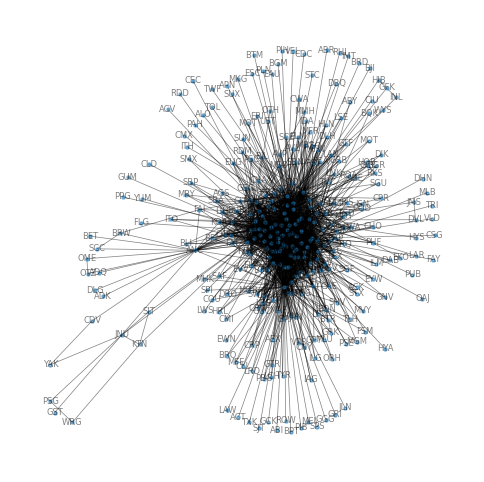

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nx.draw_networkx(grafo, ax=ax, node_size=5,
                 font_size=6, alpha=.5,
                 width=.5)
ax.set_axis_off()

## Add attributes

### Node features

In [12]:
flights.columns

Index(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'YEAR', 'MONTH', 'DAY',
       'DAY_OF_WEEK', 'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME',
       'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME',
       'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'number_flights'],
      dtype='object')

In [13]:
node_features = ['DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'WHEELS_ON',
                 'DIVERTED', 'CANCELLED', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
                 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

for feature in node_features:
    
    airport_feature = flights.groupby(['ORIGIN_AIRPORT']).mean().reset_index()[['ORIGIN_AIRPORT',feature]]
    feature_dict = airport_feature.set_index('ORIGIN_AIRPORT').to_dict()[feature]

    # Set features
    nx.set_node_attributes(grafo, feature_dict, name=feature)    
    
    if feature == 'DEPARTURE_DELAY':
        print('min: ', np.min(list(feature_dict.values())))
        print('max: ', np.max(list(feature_dict.values())))
        print('mean: ', np.mean(list(feature_dict.values())))
        print('std: ', np.std(list(feature_dict.values())))
        
        
        y_dict = {}
        for iata, delay in feature_dict.items():
            if delay < 60:
                # less than 45 minutes delay
                y_dict[iata] = 1
            #elif delay >= 45 and delay < 60:
                # 45 to 60 minutes delay
                #y_dict[iata] = 1
            else:
                # Late more than 60 minutes
                y_dict[iata] = 0
        
        # Set features
        nx.set_node_attributes(grafo, y_dict, name='y')    

# Position
position = {}
for airport_code, pos in airports_dict.items():
    position[airport_code] = (pos['LONGITUDE'], pos['LATITUDE'])
nx.set_node_attributes(grafo, position, name='POSITION') 
    
# Name:
airport_name = {}
for airport_code, pos in airports_dict.items():
    airport_name[airport_code] = pos['AIRPORT']
nx.set_node_attributes(grafo, airport_name, name='AIRPORT') 

min:  23.78787878787879
max:  184.57142857142856
mean:  61.28208710093558
std:  14.104790822144066


In [14]:
grafo.nodes['ABE']

{'DEPARTURE_DELAY': 60.66027078058996,
 'y': 0,
 'TAXI_OUT': 19.107162791918785,
 'WHEELS_OFF': 1457.6767964654491,
 'ELAPSED_TIME': 130.59015231844586,
 'WHEELS_ON': 1586.7519148905865,
 'DIVERTED': 0.0,
 'CANCELLED': 0.0,
 'AIR_SYSTEM_DELAY': 18.939085050342467,
 'SECURITY_DELAY': 0.0,
 'AIRLINE_DELAY': 21.1777201682537,
 'LATE_AIRCRAFT_DELAY': 27.764716298463327,
 'WEATHER_DELAY': 0.8810895852770613,
 'POSITION': (-75.4404, 40.65236),
 'AIRPORT': 'Lehigh Valley International Airport'}

In [15]:
edge_features = ['AIR_TIME', 'DISTANCE', 'number_flights']

for feature in edge_features:
    
    airport_feature = flights.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).mean().reset_index()[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',feature]]    
    feature_dict = airport_feature.set_index(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).to_dict()[feature]

    # Set features
    nx.set_edge_attributes(grafo, feature_dict, name=feature)


In [16]:
grafo.edges[('ABE', 'ATL')]

{'AIR_TIME': 94.195530726257, 'DISTANCE': 692.0, 'number_flights': 179.0}

# 3. Análisis del Gráfo (Graph analysis):

### 3.1 Información del Grafo (Graph Information)

In [17]:
# Información básica sobre el dataset:
print(50*'=')
print(f'Número de grafos (graphs): {1}')
print(f'Número de nodos (nodes): {len(grafo.nodes())}')
print(f'Número de vertices (edges): {len(grafo.edges())}')
print(50*'=')

Número de grafos (graphs): 1
Número de nodos (nodes): 321
Número de vertices (edges): 2314


### 3.2. Matriz de Adyacencia (Adjacency Matrix)

In [18]:
A = nx.adjacency_matrix(grafo)
#A.setdiag(1)
print(A.todense())

[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [19]:
if np.all(A.T.todense() == A.todense()):
    print('La matriz de adyacencia y su transpuesta son iguales, por lo tanto es no dirigido (Is undirected)')

La matriz de adyacencia y su transpuesta son iguales, por lo tanto es no dirigido (Is undirected)


### 3.3. Vecindad (neighborhood)

In [20]:
# Método 1 (Method 1)
# Podemos calcularla sumando las filas (columnas, porque es simétrica al ser no dirigido) de la matriz de adyacencia
np.sum(A, axis=0)

matrix([[  3, 168, 111, 161,   1, 149,  23,  66,  68,  52, 140,  51, 118,
          64,  78,  80,  41,  73,  69, 120,  35,  48,  77,  45,  73,  79,
          89,   1,   1,   3,  61,  57,   1,   1,  10,  61,  17,  25,  40,
          61,   1,  29,   1,   3,   2,  15,  87,  70,   1,   5,   1,   3,
           2,   1,   5,  28,   7,  12,  11,  18,   2,   2,   2,   1,   8,
           4,  41,   3,   4,   4,  25,  15,   7,  47,   1,   4,   7,  18,
          12,   7,  12,   4,   3,  21,   7,  35,  28,  10,   5,   1,  37,
           2,  12,   1,  12,   7,  11,   3,  12,   4,   1,   3,   6,   1,
           6,   8,   5,   2,   5,   2,   3,   4,   3,  16,  10,  12,   1,
          10,   9,   8,  10,   3,  30,  13,   4,  22,   4,   8,   4,  67,
          12,   5,   4,   6,  23,   2,  11,  52,  28,   1,   6,   3,   5,
          12,   7,  37,  10,   1,  22,  19,  16,   3,  46,   7,  30,   9,
          15,  10,   7,  36,  16,   3,  13,   5,  30,  10,   6,   3,  17,
           5,   4,  25,  23,  27,  22,

In [21]:
# Método 2 (Method 2)
# También podemos usar la función degree de networkx:
# La diferencia entre los dos métodos es que el primer método (Sumando de la matriz) cuenta también los self-loops
grados = grafo.degree()
grados

DegreeView({'ABE': 3, 'ATL': 168, 'DTW': 111, 'ORD': 161, 'ABI': 1, 'DFW': 149, 'ABQ': 23, 'BWI': 66, 'CLT': 68, 'DAL': 52, 'DEN': 140, 'HOU': 51, 'IAH': 118, 'JFK': 64, 'LAS': 78, 'LAX': 80, 'MCI': 41, 'MCO': 73, 'MDW': 69, 'MSP': 120, 'OAK': 35, 'PDX': 48, 'PHX': 77, 'SAN': 45, 'SEA': 73, 'SFO': 79, 'SLC': 89, 'ABR': 1, 'ABY': 1, 'ACK': 3, 'BOS': 61, 'DCA': 57, 'ACT': 1, 'ACV': 1, 'ACY': 10, 'FLL': 61, 'MYR': 17, 'PBI': 25, 'RSW': 40, 'TPA': 61, 'ADK': 1, 'ANC': 29, 'ADQ': 1, 'AEX': 3, 'AGS': 2, 'ALB': 15, 'EWR': 87, 'IAD': 70, 'ALO': 1, 'AMA': 5, 'BET': 1, 'BRW': 3, 'CDV': 2, 'DLG': 1, 'FAI': 5, 'HNL': 28, 'JNU': 7, 'KOA': 12, 'LGB': 11, 'OGG': 18, 'OME': 2, 'OTZ': 2, 'SCC': 2, 'APN': 1, 'ASE': 8, 'ATW': 4, 'AUS': 41, 'AVL': 3, 'AVP': 4, 'AZO': 4, 'BDL': 25, 'BHM': 15, 'BMI': 7, 'BNA': 47, 'BQK': 1, 'BTR': 4, 'BTV': 7, 'BUF': 18, 'BZN': 12, 'CAE': 7, 'CAK': 12, 'CHA': 4, 'CHO': 3, 'CHS': 21, 'CID': 7, 'CLE': 35, 'CMH': 28, 'COS': 10, 'CRW': 5, 'CSG': 1, 'CVG': 37, 'DAB': 2, 'DAY': 1

In [22]:
grados = np.array(grados)

# Nodo con el máximo grado (Max degree node):
# Indide del máximo valor
index = np.argmax(grados[:,1])
max_d = grados[index, 1]
print(f'El grado máximo es el nodo (node): {grados[index, 0]} con un in-degree/ out-degree: {max_d}')

# Nodo con el mínimo grado (Min degree node):
# Indide del mínimo valor
index = np.argmin(grados[:,1])
print(f'El grado mínimo es el nodo (node): {grados[index, 0]} con un in-degree/ out-degree: {grados[index, 1]}')

# Grado promedio (Mean degree):
mean = grados[:,1].astype(int).mean()
print(f'El Grado promedio (Mean degree): {mean}')
std = grados[:,1].astype(int).std()
print(f'Standard deviation: {std}')

El grado máximo es el nodo (node): HPN con un in-degree/ out-degree: 9
El grado mínimo es el nodo (node): ABI con un in-degree/ out-degree: 1
El Grado promedio (Mean degree): 14.417445482866043
Standard deviation: 25.917317747146008


### 3.4. Distribución de grado en el grafo (Degree distribution of the graph)

#### 1. Probability Density Function (PDF)
#### 2. Complementary Cumulative Distribution Function (CCDF)

In [23]:
# Nos quedamos solo con los grados (Take just the degrees)
valores_grado = grados[:,1].astype(int)
valores_grado.sort()
valores_grado

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         2,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   5,   5,   5,   5,   5,   5,   5,   

### 3.4.1. PDF

In [24]:
def plot_pdf(pdf, grado_indice, x=None, y=None):
    grid = sns.lineplot(x=grado_indice, y=pdf)
    grid.set(xlim=0)

    if x=='log' and y=='log':
        grid.set(xscale="log", yscale="log")
        plt.xlabel('Grado [log]')
        plt.ylabel('Probabilidad [log]')
        plt.title('PDF log - log')

    elif x=='log':
        grid.set(xscale="log")
        plt.xlabel('Grado [log]')
        plt.ylabel('Probabilidad')
        plt.title('PDF linear - log')
    elif y=='log':
        grid.set(yscale="log")
        plt.xlabel('Grado')
        plt.ylabel('Probabilidad [log]')
        plt.title('PDF log - linear')
    else:
        plt.xlabel('Grado')
        plt.ylabel('Probabilidad')
        plt.title('PDF')
    grid.set(xlim=0)
    plt.savefig(f'pdf_grado_{x}-{y}.png')
    plt.show()

In [25]:
pdf, ecdf, grado_indice = distribucion_probabilidades(valores_grado)

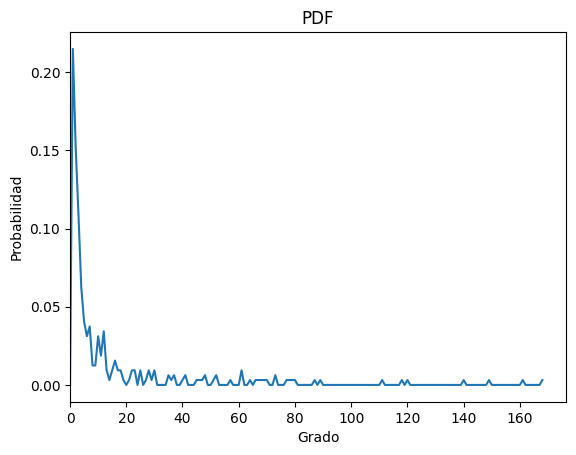

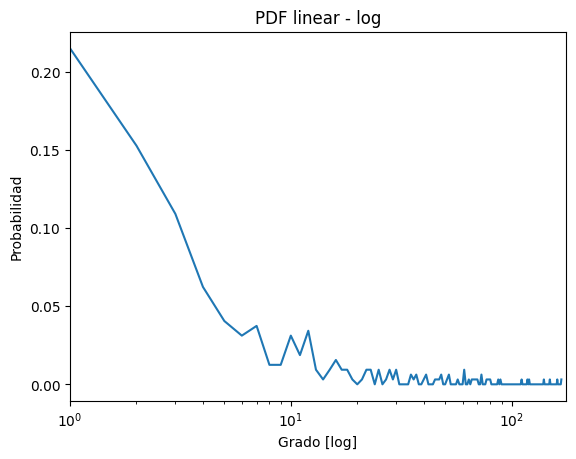

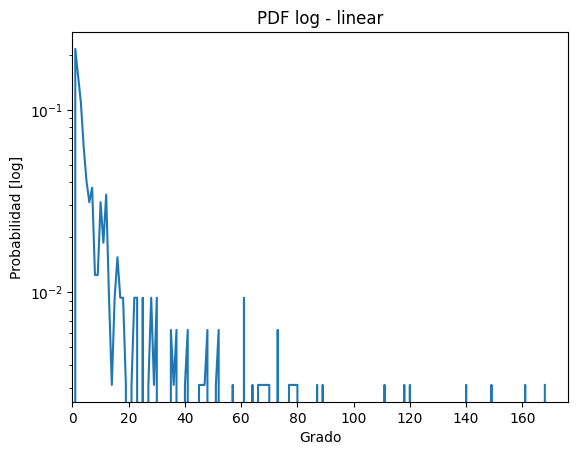

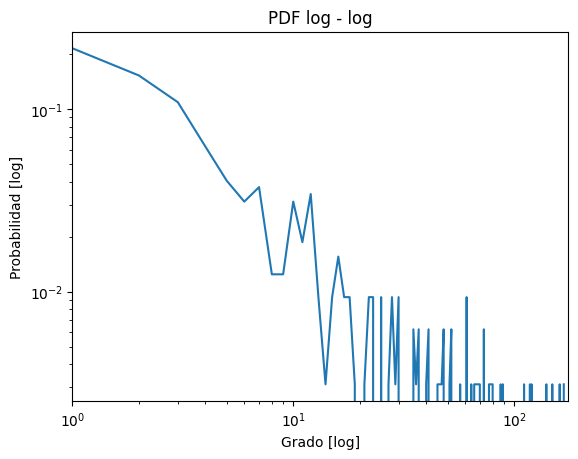

In [26]:
plot_pdf(pdf, grado_indice, x=None, y=None)
plot_pdf(pdf, grado_indice, x='log', y=None)
plot_pdf(pdf, grado_indice, x=None, y='log')
plot_pdf(pdf, grado_indice, x='log', y='log')

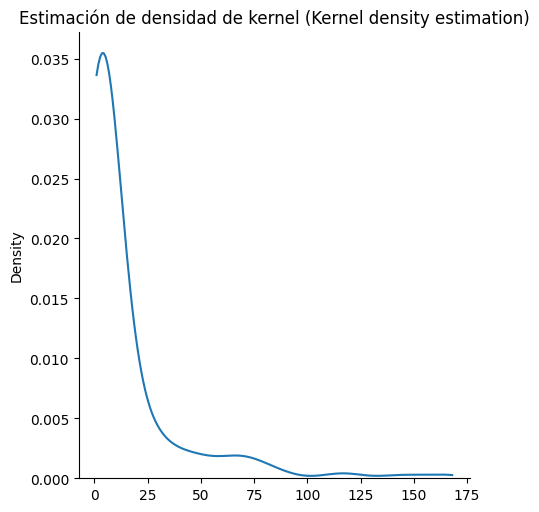

In [27]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.displot(degrees, kind="kde", cut=0)
    plt.title('Estimación de densidad de kernel (Kernel density estimation)')
    plt.show()

plot_degree_dist(grafo)

### 3.4.2. Función de distribución de probabilidad acomulada empírica (empirical cumulative distribution function) (ECDF)

In [28]:
def plot_ecdf(ecdf, grado_indice, x=None, y=None):
    grid = sns.lineplot(x=grado_indice, y=ecdf)
    grid.set(xlim=0)

    if x=='log' and y=='log':
        grid.set(xscale="log", yscale="log")
        plt.xlabel('Grado [log]')
        plt.ylabel('Probabilidad [log]')
        plt.title('ECDF log - log')

    elif x=='log':
        grid.set(xscale="log")
        plt.xlabel('Grado [log]')
        plt.ylabel('Probabilidad')
        plt.title('ECDF linear - log')
    elif y=='log':
        grid.set(yscale="log")
        plt.xlabel('Grado')
        plt.ylabel('Probabilidad [log]')
        plt.title('ECDF log - linear')
    else:
        plt.xlabel('Grado')
        plt.ylabel('Probabilidad')
        plt.title('ECDF')
    grid.set(xlim=0)
    plt.savefig(f'ecdf_grado_{x}-{y}.png')
    plt.show()

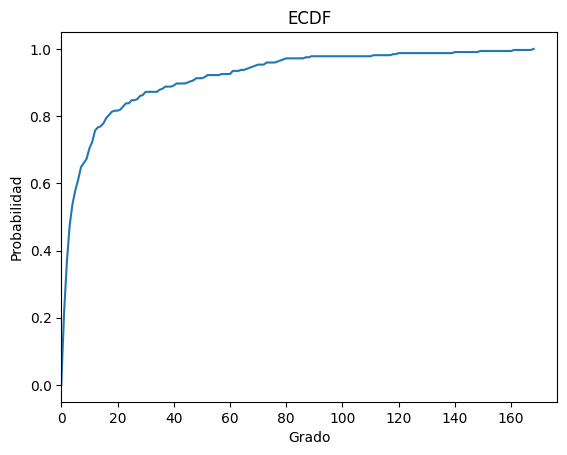

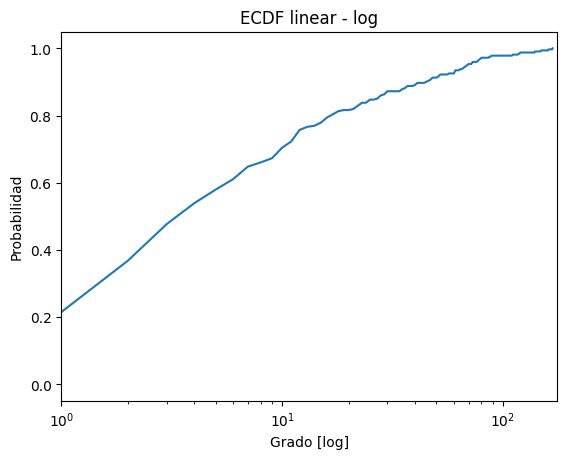

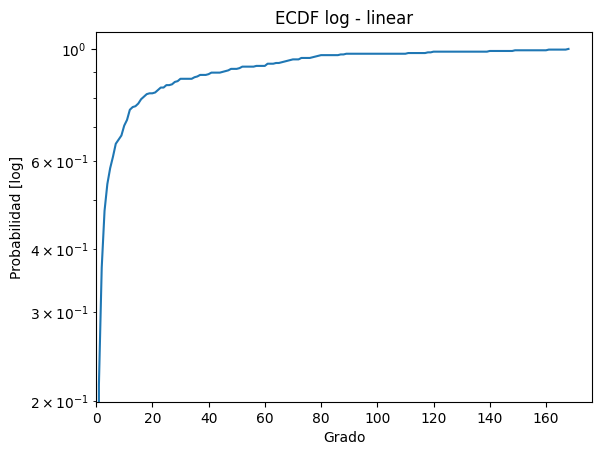

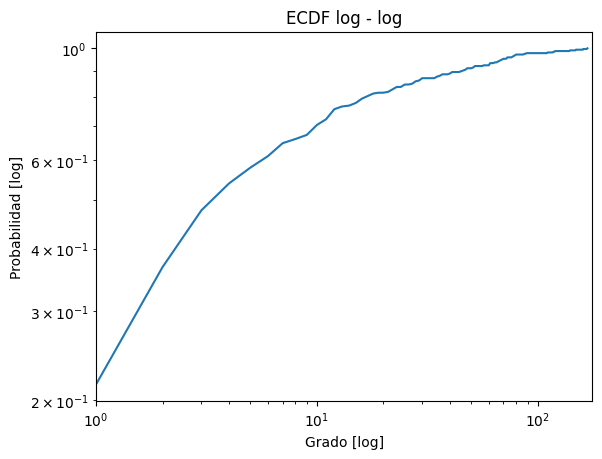

In [29]:
plot_ecdf(ecdf, grado_indice, x=None, y=None)
plot_ecdf(ecdf, grado_indice, x='log', y=None)
plot_ecdf(ecdf, grado_indice, x=None, y='log')
plot_ecdf(ecdf, grado_indice, x='log', y='log')

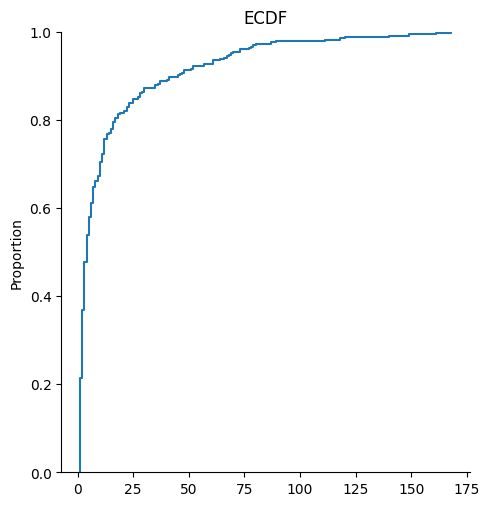

In [30]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = [G.degree(n) for n in G.nodes()]
    sns.displot(degrees, kind="ecdf")
    plt.title('ECDF')
    plt.show()

plot_degree_dist(grafo)

### Plot degree

In [31]:
# Definimos el tamaño del nodo con el grado:
grados = grafo.degree()
sizes = [grados[code] * 3 for code in grafo.nodes]

In [32]:
delay = [grafo.nodes[code]['DEPARTURE_DELAY'] for code in grafo.nodes]

labels = {code:grafo.nodes[code]['AIRPORT'] if grados[code] >= 120 else '' for code in grafo.nodes}
#labels

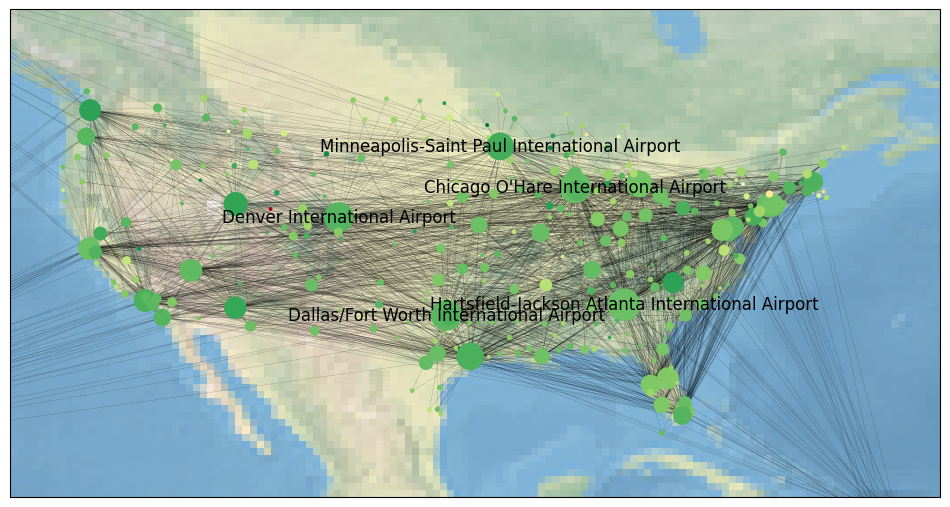

In [33]:
# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(grafo, 
                 ax=ax,
                 font_size=12,
                 alpha=1,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=position,
                 node_color=delay,
                 cmap=plt.cm.RdYlGn_r)

In [34]:
GRADOS_LIM = 80

subgrafo = []

for iata in grafo.nodes:
    if grados[iata] >= GRADOS_LIM: 
        subgrafo.append(iata)

subgrafo

['ATL', 'DTW', 'ORD', 'DFW', 'DEN', 'IAH', 'LAX', 'MSP', 'SLC', 'EWR']

In [35]:
subgrafo = grafo.subgraph(subgrafo)

# Definimos el tamaño del nodo con el grado:
sub_grados = subgrafo.degree()
sizes = [grados[code]**1.5 for code in subgrafo.nodes]

# Delay for color
delay = [grafo.nodes[code]['DEPARTURE_DELAY'] for code in subgrafo.nodes]

# Labels:
labels_subgrafo = {code:grafo.nodes[code]['AIRPORT'] if grados[code] >= GRADOS_LIM else '' for code in grafo.nodes}

for iata, atts in labels_subgrafo.items():
    if atts == 'Detroit Metropolitan Airport':
        labels_subgrafo[iata] = 'Detroit'
    elif atts == "Chicago O'Hare International Airport":
        labels_subgrafo[iata] = "Chicago O'H"
    else:
        continue

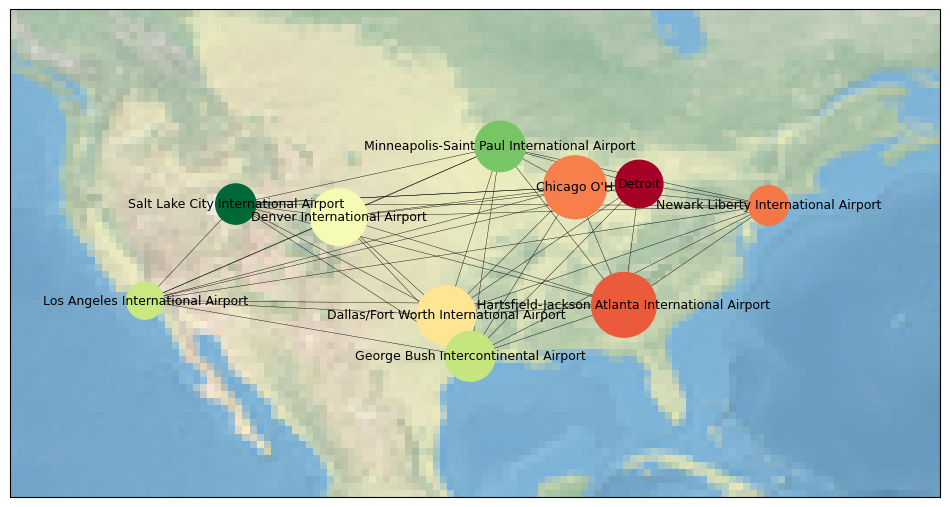

In [36]:
# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw =dict(projection=crs))

#ax.coastlines()
ax.stock_img()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(subgrafo, 
                 ax=ax,
                 font_size=9,
                 alpha=1,
                 width=.3,
                 node_size=sizes,
                 labels=labels_subgrafo,
                 pos=position,
                 node_color=delay,
                 cmap=plt.cm.RdYlGn_r)

### 3.5. Coeficiente de Agrupamiento

In [37]:
clustering_coef = nx.clustering(grafo)
clustering_coef

{'ABE': 1.0,
 'ATL': 0.12382378100940976,
 'DTW': 0.2167076167076167,
 'ORD': 0.12437888198757764,
 'ABI': 0,
 'DFW': 0.1326863776528206,
 'ABQ': 0.924901185770751,
 'BWI': 0.4624708624708625,
 'CLT': 0.4754170324846356,
 'DAL': 0.5082956259426847,
 'DEN': 0.15991778006166496,
 'HOU': 0.4752941176470588,
 'IAH': 0.1944082283065334,
 'JFK': 0.3814484126984127,
 'LAS': 0.3996003996003996,
 'LAX': 0.3566455696202532,
 'MCI': 0.7451219512195122,
 'MCO': 0.3820395738203957,
 'MDW': 0.3976982097186701,
 'MSP': 0.1896358543417367,
 'OAK': 0.6134453781512605,
 'PDX': 0.5531914893617021,
 'PHX': 0.38516746411483255,
 'SAN': 0.6626262626262627,
 'SEA': 0.3919330289193303,
 'SFO': 0.3021746186303148,
 'SLC': 0.24336057201225741,
 'ABR': 0,
 'ABY': 0,
 'ACK': 1.0,
 'BOS': 0.5398907103825137,
 'DCA': 0.5244360902255639,
 'ACT': 0,
 'ACV': 0,
 'ACY': 0.7333333333333333,
 'FLL': 0.46612021857923497,
 'MYR': 0.5588235294117647,
 'PBI': 0.59,
 'RSW': 0.5,
 'TPA': 0.4644808743169399,
 'ADK': 0,
 'ANC': 

In [38]:
# Nodo con el máximo grado (Max degree node):
# Indide del máximo valor
index = max(clustering_coef, key=clustering_coef.get)
print(f'El coeficiente de agrupamiento máximo es el nodo (node): {index} con un in-degree/ out-degree: {clustering_coef[index]}')

# Nodo con el mínimo grado (Min degree node):
# Indide del mínimo valor
index = min(clustering_coef, key=clustering_coef.get)
print(f'El coeficiente de agrupamiento mínimo es el nodo (node): {index} con un in-degree/ out-degree: {clustering_coef[index]}')

# Grado promedio (Mean degree):
mean = np.mean(list(clustering_coef.values()))
print(f'El coeficiente de agrupamiento promedio (Mean degree): {mean}')
std = np.std(list(clustering_coef.values()))
print(f'Standard deviation: {std}')

El coeficiente de agrupamiento máximo es el nodo (node): ABE con un in-degree/ out-degree: 1.0
El coeficiente de agrupamiento mínimo es el nodo (node): ABI con un in-degree/ out-degree: 0
El coeficiente de agrupamiento promedio (Mean degree): 0.6550382386520311
Standard deviation: 0.40876220360048915


In [39]:
# Nos quedamos solo con los grados (Take just the degrees)
clustering_coef = np.array(list(clustering_coef.values()))
clustering_coef.sort()
clustering_coef

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.12382

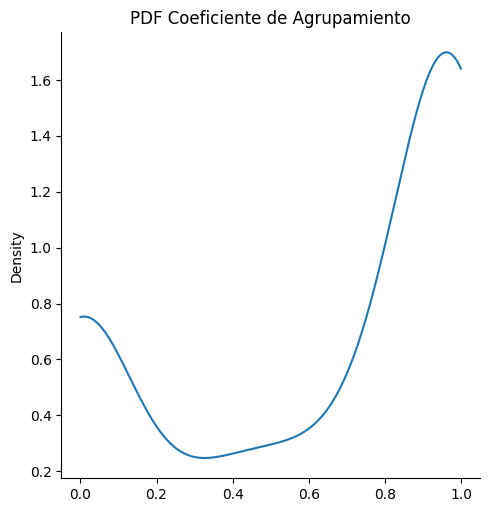

In [40]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = [nx.clustering(G, n) for n in G.nodes()]
    sns.displot(degrees, kind="kde", cut=0)
    plt.title('PDF Coeficiente de Agrupamiento')
    plt.show()

plot_degree_dist(grafo)

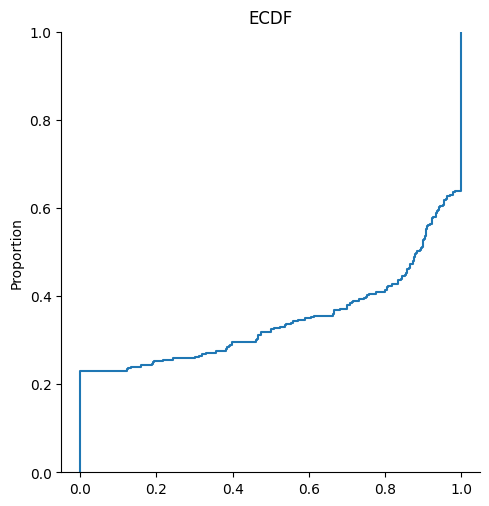

In [41]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = [nx.clustering(G, n) for n in G.nodes()]
    sns.displot(degrees, kind="ecdf")
    plt.title('ECDF')
    plt.show()

plot_degree_dist(grafo)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


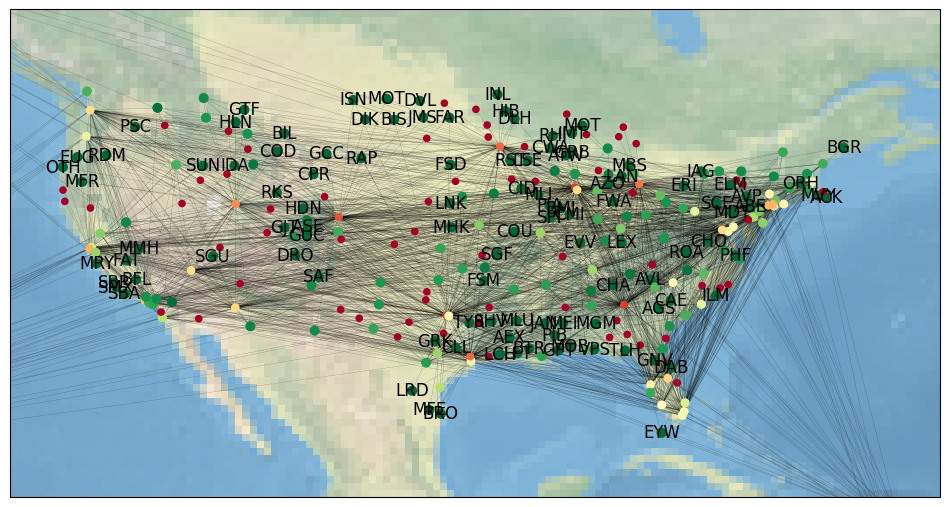

In [42]:
# Definimos el tamaño del nodo con el grado:
coef = nx.clustering(grafo)#, list(nx.get_edge_attributes(grafo,'DISTANCE').values()))
sizes = [(coef[code]+1) * 20 for code in grafo.nodes]

delay = [grafo.nodes[code]['DEPARTURE_DELAY'] for code in grafo.nodes]
labels = {code:code if coef[code] == 1 else '' for code in grafo.nodes}

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(grafo, 
                 ax=ax,
                 font_size=12,
                 alpha=1,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

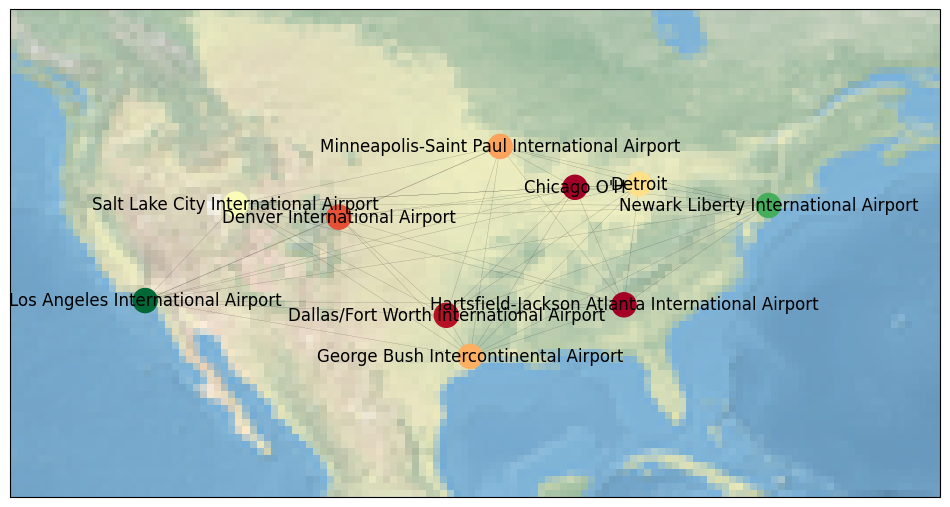

In [43]:
subgrafo = grafo.subgraph(subgrafo)

# Definimos el tamaño del nodo con el grado:
sizes = [(coef[code]+1) * 20 for code in subgrafo.nodes]

delay = [subgrafo.nodes[code]['DEPARTURE_DELAY'] for code in subgrafo.nodes]

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(subgrafo, 
                 ax=ax,
                 font_size=12,
                 alpha=1,
                 width=.075,
                 node_size=300,
                 labels=labels_subgrafo,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

### 4.1. Medidas de Centralidad: Centralidad por Cercanía

In [44]:
clustering_coef = nx.closeness_centrality(grafo)
clustering_coef

{'ABE': 0.4227212681638045,
 'ATL': 0.6722689075630253,
 'DTW': 0.5882352941176471,
 'ORD': 0.6625258799171843,
 'ABI': 0.3931203931203931,
 'DFW': 0.6464646464646465,
 'ABQ': 0.4984423676012461,
 'BWI': 0.5423728813559322,
 'CLT': 0.545144804088586,
 'DAL': 0.4984423676012461,
 'DEN': 0.6349206349206349,
 'HOU': 0.5031446540880503,
 'IAH': 0.6072106261859582,
 'JFK': 0.5423728813559322,
 'LAS': 0.5653710247349824,
 'LAX': 0.5673758865248227,
 'MCI': 0.5203252032520326,
 'MCO': 0.5498281786941581,
 'MDW': 0.5152979066022544,
 'MSP': 0.6106870229007634,
 'OAK': 0.5015673981191222,
 'PDX': 0.5333333333333333,
 'PHX': 0.564373897707231,
 'SAN': 0.5245901639344263,
 'SEA': 0.564373897707231,
 'SFO': 0.5663716814159292,
 'SLC': 0.5734767025089605,
 'ABR': 0.37959667852906287,
 'ABY': 0.4025157232704403,
 'ACK': 0.36199095022624433,
 'BOS': 0.5387205387205387,
 'DCA': 0.5342237061769616,
 'ACT': 0.3931203931203931,
 'ACV': 0.36199095022624433,
 'ACY': 0.43243243243243246,
 'FLL': 0.530679933

In [45]:
# Nodo con el máximo grado (Max degree node):
# Indide del máximo valor
index = max(clustering_coef, key=clustering_coef.get)
print(f'La centralidad por cercania máxima es el nodo: {index} = {clustering_coef[index]}')

# Nodo con el mínimo grado (Min degree node):
# Indide del mínimo valor
index = min(clustering_coef, key=clustering_coef.get)
print(f'La centralidad por cercania mínima es el nodo: {index} = {clustering_coef[index]}')

# Grado promedio (Mean degree):
mean = np.mean(list(clustering_coef.values()))
print(f'La centralidad por cercania promedio: {mean}')
std = np.std(list(clustering_coef.values()))
print(f'Desviación estándar: {std}')

La centralidad por cercania máxima es el nodo: ATL = 0.6722689075630253
La centralidad por cercania mínima es el nodo: WRG = 0.26755852842809363
La centralidad por cercania promedio: 0.4319072761982609
Desviación estándar: 0.06361781349480002


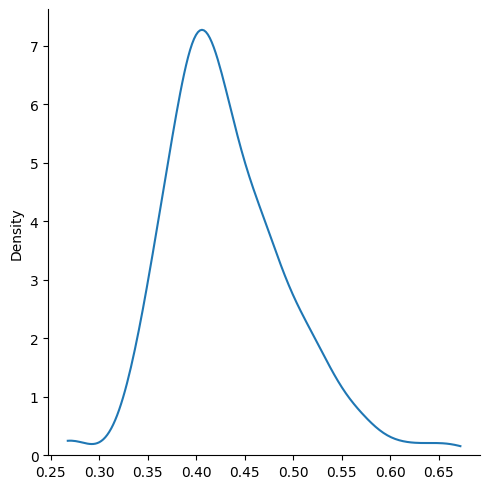

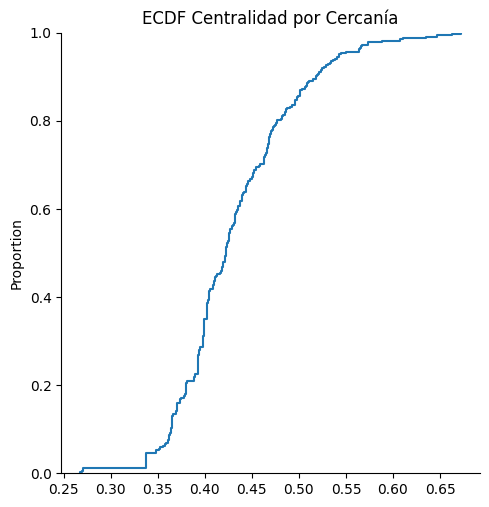

In [46]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = [nx.closeness_centrality(G, n) for n in G.nodes()]
    grid = sns.displot(degrees, kind="kde", cut=0)

    plt.show()

plot_degree_dist(grafo)

# Kernel density estimation:
def plot_degree_dist(G):
    degrees = [nx.closeness_centrality(G, n) for n in G.nodes()]
    sns.displot(degrees, kind="ecdf")
    plt.title('ECDF Centralidad por Cercanía')
    plt.show()

plot_degree_dist(grafo)

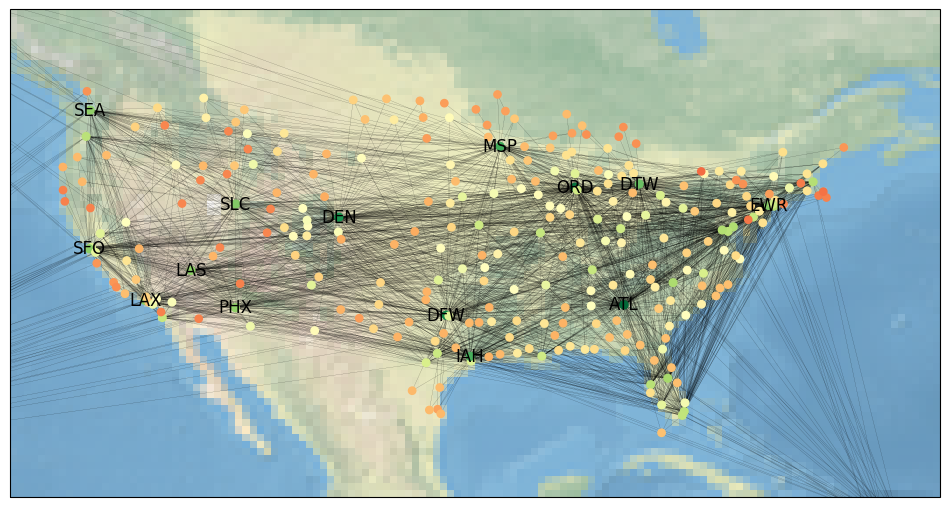

In [47]:
# Definimos el tamaño del nodo con el grado:
coef = nx.closeness_centrality(grafo)
sizes = [(coef[code]+1) * 20 for code in grafo.nodes]

delay = [grafo.nodes[code]['DEPARTURE_DELAY'] for code in grafo.nodes]
labels = {code:code if coef[code] > .55 else '' for code in grafo.nodes}

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(grafo, 
                 ax=ax,
                 font_size=12,
                 alpha=1,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

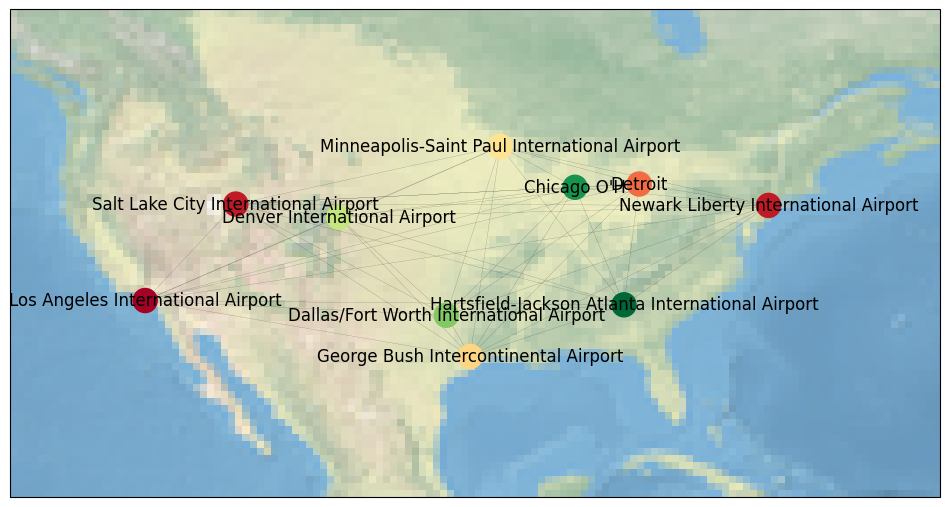

In [48]:
subgrafo = grafo.subgraph(subgrafo)

# Definimos el tamaño del nodo con el grado:
sizes = [(coef[code]+1) * 20 for code in subgrafo.nodes]

delay = [subgrafo.nodes[code]['DEPARTURE_DELAY'] for code in subgrafo.nodes]

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(subgrafo, 
                 ax=ax,
                 font_size=12,
                 alpha=1,
                 width=.075,
                 node_size=300,
                 labels=labels_subgrafo,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

### 4.2  Medidas de Centralidad: Centralidad por intermediación

In [49]:
clustering_coef = nx.betweenness_centrality(grafo)
clustering_coef

{'ABE': 0.0,
 'ATL': 0.17463399570790572,
 'DTW': 0.0714239875741192,
 'ORD': 0.15219727490715,
 'ABI': 0.0,
 'DFW': 0.16806508300408038,
 'ABQ': 5.98009329615958e-05,
 'BWI': 0.005530359856835251,
 'CLT': 0.008766657496984851,
 'DAL': 0.0026430202143738536,
 'DEN': 0.11788431593844367,
 'HOU': 0.00441000733386177,
 'IAH': 0.06305952759012266,
 'JFK': 0.020417554791240994,
 'LAS': 0.012481031327556779,
 'LAX': 0.027836282246423573,
 'MCI': 0.0017508395974884228,
 'MCO': 0.01921817272382576,
 'MDW': 0.00472165896711356,
 'MSP': 0.09584058338987697,
 'OAK': 0.001670040786410727,
 'PDX': 0.003715962706328699,
 'PHX': 0.02636247497568201,
 'SAN': 0.0016883529107604926,
 'SEA': 0.044322442063748954,
 'SFO': 0.04435148379344481,
 'SLC': 0.08353210951639985,
 'ABR': 0.0,
 'ABY': 0.0,
 'ACK': 0.0,
 'BOS': 0.008511905573868377,
 'DCA': 0.005657650132929182,
 'ACT': 0.0,
 'ACV': 0.0,
 'ACY': 1.9646716622046024e-05,
 'FLL': 0.018180251542405306,
 'MYR': 0.003426165200932274,
 'PBI': 0.00160583771

In [50]:
# Nodo con el máximo grado (Max degree node):
# Indide del máximo valor
index = max(clustering_coef, key=clustering_coef.get)
print(f'La centralidad por intermediación máxima es el nodo: {index} = {clustering_coef[index]}')

# Nodo con el mínimo grado (Min degree node):
# Indide del mínimo valor
index = min(clustering_coef, key=clustering_coef.get)
print(f'La centralidad por intermediación mínima es el nodo: {index} = {clustering_coef[index]}')

# Grado promedio (Mean degree):
mean = np.mean(list(clustering_coef.values()))
print(f'La centralidad por intermediación promedio: {mean}')
std = np.std(list(clustering_coef.values()))
print(f'Desviación estándar: {std}')

La centralidad por intermediación máxima es el nodo: ATL = 0.17463399570790572
La centralidad por intermediación mínima es el nodo: ABE = 0.0
La centralidad por intermediación promedio: 0.0042754323772693096
Desviación estándar: 0.019929800135883295


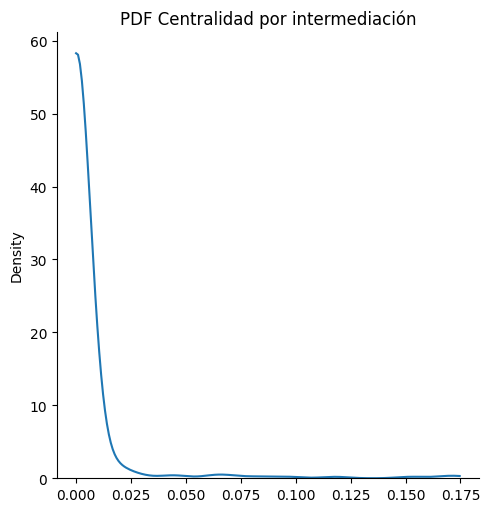

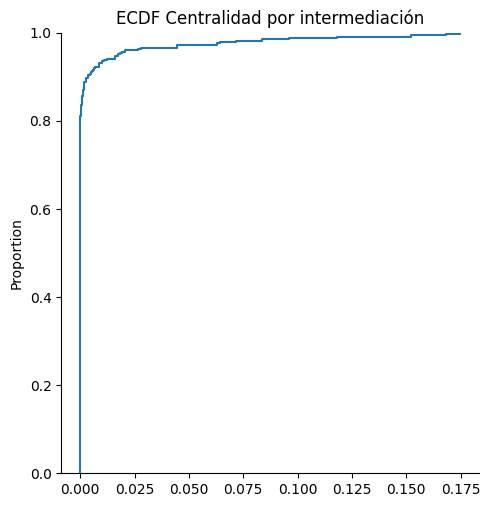

In [51]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = list(clustering_coef.values())
    grid = sns.displot(degrees, kind="kde", cut=0)
    #grid.set(xscale="log", yscale="log")
    #plt.xlabel('Centralidad por intermediación [log]')
    #plt.ylabel('Probabilidad [log]')
    plt.title('PDF Centralidad por intermediación')
    plt.show()

plot_degree_dist(grafo)

# Kernel density estimation:
def plot_degree_dist(G):
    degrees = list(clustering_coef.values())
    sns.displot(degrees, kind="ecdf")
    plt.title('ECDF Centralidad por intermediación')
    plt.show()

plot_degree_dist(grafo)

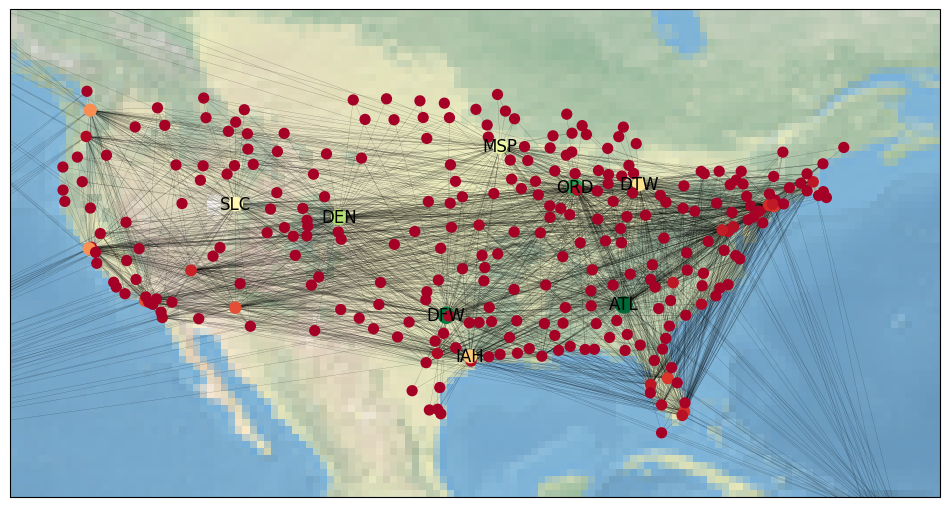

In [52]:
# Definimos el tamaño del nodo con el grado:
coef = nx.betweenness_centrality(grafo)
sizes = [(coef[code]+0.1) * 500 for code in grafo.nodes]

delay = [grafo.nodes[code]['DEPARTURE_DELAY'] for code in grafo.nodes]
labels = {code:code if coef[code] > .045 else '' for code in grafo.nodes}

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(grafo, 
                 ax=ax,
                 font_size=12,
                 alpha=1,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

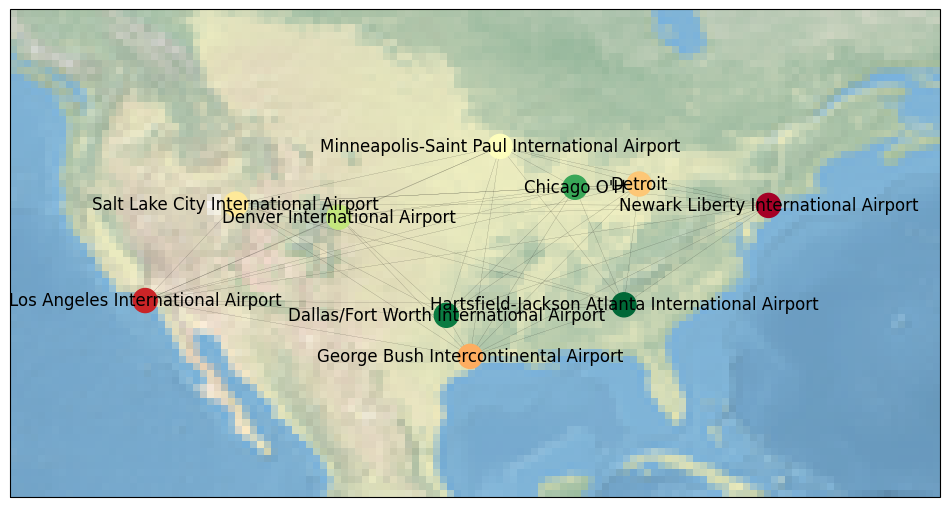

In [53]:
subgrafo = grafo.subgraph(subgrafo)

# Definimos el tamaño del nodo con el grado:
sizes = [(coef[code]+1) * 20 for code in subgrafo.nodes]

delay = [subgrafo.nodes[code]['DEPARTURE_DELAY'] for code in subgrafo.nodes]

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(subgrafo, 
                 ax=ax,
                 font_size=12,
                 alpha=1,
                 width=.075,
                 node_size=300,
                 labels=labels_subgrafo,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

### 4.2  Medidas de Centralidad: Eigenvector

In [54]:
clustering_coef = nx.eigenvector_centrality_numpy(grafo, max_iter=100)
clustering_coef

{'ABE': 0.012203956714530406,
 'ATL': 0.20272702625909517,
 'DTW': 0.16875219344986225,
 'ORD': 0.1958925200126963,
 'ABI': 0.003968060214172892,
 'DFW': 0.18447830320104358,
 'ABQ': 0.07173364302749026,
 'BWI': 0.14267910919077653,
 'CLT': 0.14732144840723563,
 'DAL': 0.1150902223018882,
 'DEN': 0.18659308870833072,
 'HOU': 0.11024550403695,
 'IAH': 0.1738557796425532,
 'JFK': 0.1262601747549491,
 'LAS': 0.1565378963725753,
 'LAX': 0.15123467217604086,
 'MCI': 0.11248137435439479,
 'MCO': 0.1443564066016248,
 'MDW': 0.1393419885861451,
 'MSP': 0.1728710467379792,
 'OAK': 0.08216046446655483,
 'PDX': 0.10863573069001616,
 'PHX': 0.15049949477954738,
 'SAN': 0.11304510186570056,
 'SEA': 0.1425033662926404,
 'SFO': 0.13744029374592404,
 'SLC': 0.13870360793595302,
 'ABR': 0.0037183924116856283,
 'ABY': 0.00436058351187042,
 'ACK': 0.0085292876055775,
 'BOS': 0.14042839380634722,
 'DCA': 0.12984485584859673,
 'ACT': 0.003968060214172897,
 'ACV': 0.002956289991691299,
 'ACY': 0.02814405220

In [55]:
# Nodo con el máximo grado (Max degree node):
# Indide del máximo valor
index = max(clustering_coef, key=clustering_coef.get)
print(f'La centralidad por eigenvalue máxima es el nodo: {index} = {clustering_coef[index]}')

# Nodo con el mínimo grado (Min degree node):
# Indide del mínimo valor
index = min(clustering_coef, key=clustering_coef.get)
print(f'La centralidad por eigenvalue mínima es el nodo: {index} = {clustering_coef[index]}')

# Grado promedio (Mean degree):
mean = np.mean(list(clustering_coef.values()))
print(f'La centralidad por eigenvalue promedio: {mean}')
std = np.std(list(clustering_coef.values()))
print(f'Desviación estándar: {std}')

La centralidad por eigenvalue máxima es el nodo: ATL = 0.20272702625909517
La centralidad por eigenvalue mínima es el nodo: WRG = 7.150973812790412e-05
La centralidad por eigenvalue promedio: 0.03385487026422258
Desviación estándar: 0.044374683738596335


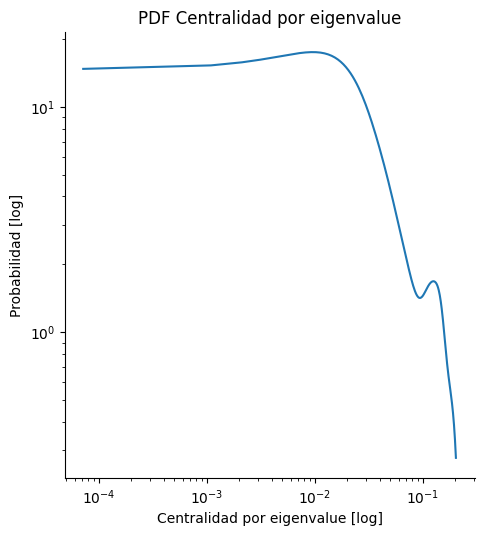

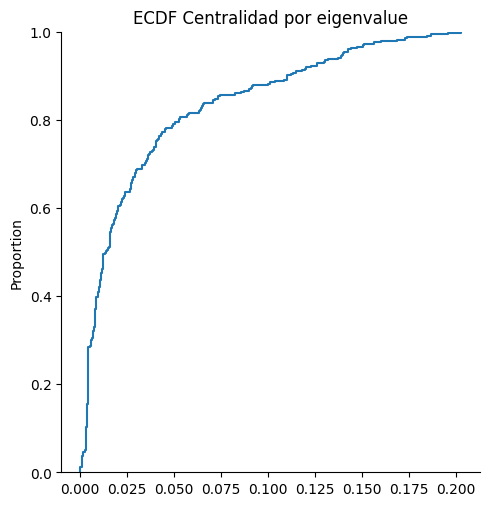

In [56]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = list(clustering_coef.values())
    grid = sns.displot(degrees, kind="kde", cut=0)
    grid.set(xscale="log", yscale="log")
    plt.xlabel('Centralidad por eigenvalue [log]')
    plt.ylabel('Probabilidad [log]')
    plt.title('PDF Centralidad por eigenvalue')
    plt.show()

plot_degree_dist(grafo)

# Kernel density estimation:
def plot_degree_dist(G):
    degrees = list(clustering_coef.values())
    sns.displot(degrees, kind="ecdf")
    plt.title('ECDF Centralidad por eigenvalue')
    plt.show()

plot_degree_dist(grafo)

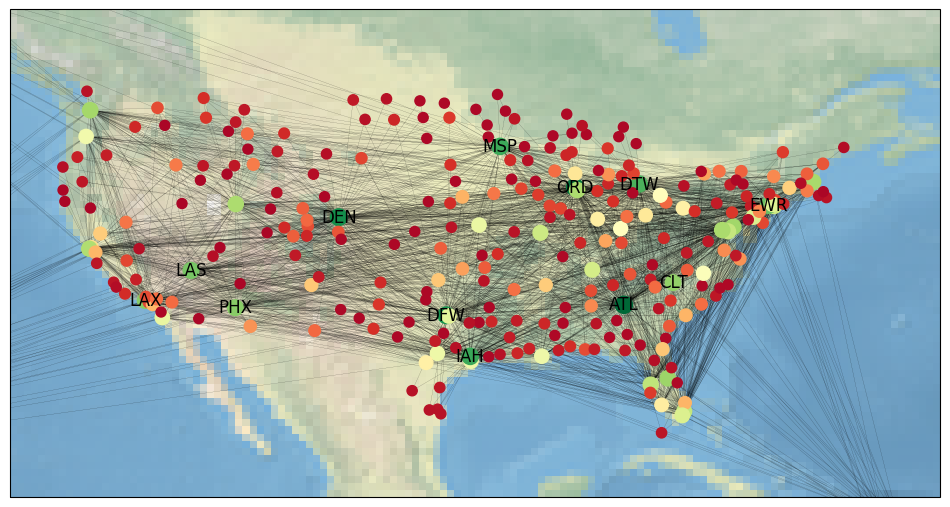

In [57]:
# Definimos el tamaño del nodo con el grado:
coef = nx.eigenvector_centrality(grafo)
sizes = [(coef[code]+0.1) * 500 for code in grafo.nodes]

delay = [grafo.nodes[code]['DEPARTURE_DELAY'] for code in grafo.nodes]
labels = {code:code if coef[code] > .145 else '' for code in grafo.nodes}

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(grafo, 
                 ax=ax,
                 font_size=12,
                 alpha=1,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

In [58]:
GRADOS_LIM = .145

subgrafo = []

for iata in grafo.nodes:
    if coef[iata] >= GRADOS_LIM: 
        subgrafo.append(iata)

subgrafo

['ATL',
 'DTW',
 'ORD',
 'DFW',
 'CLT',
 'DEN',
 'IAH',
 'LAS',
 'LAX',
 'MSP',
 'PHX',
 'EWR']

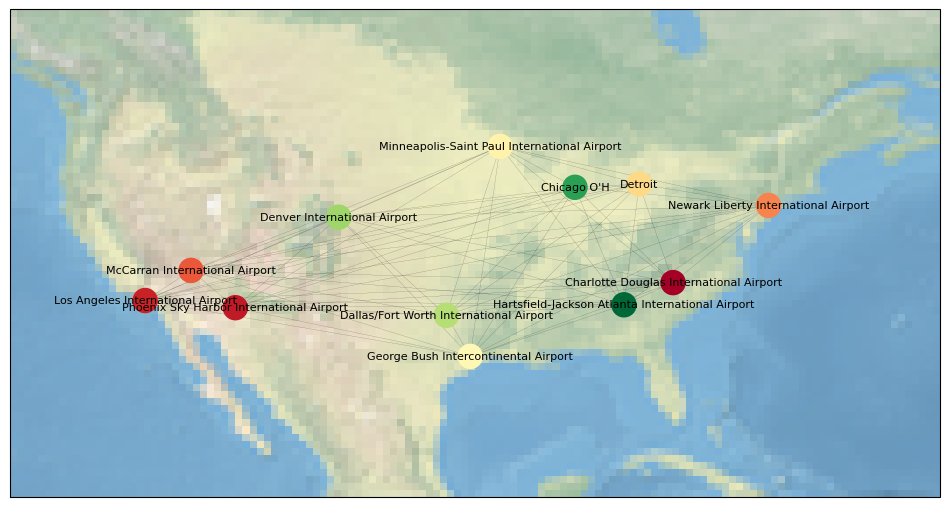

In [59]:
subgrafo = grafo.subgraph(subgrafo)

# Definimos el tamaño del nodo con el grado:
sizes = [(coef[code]+1) * 20 for code in subgrafo.nodes]

delay = [subgrafo.nodes[code]['DEPARTURE_DELAY'] for code in subgrafo.nodes]

# Labels:
labels_subgrafo = {code:grafo.nodes[code]['AIRPORT'] if coef[code] >= GRADOS_LIM else '' for code in grafo.nodes}

for iata, atts in labels_subgrafo.items():
    if atts == 'Detroit Metropolitan Airport':
        labels_subgrafo[iata] = 'Detroit'
    elif atts == "Chicago O'Hare International Airport":
        labels_subgrafo[iata] = "Chicago O'H"
    else:
        continue

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(subgrafo, 
                 ax=ax,
                 font_size=8,
                 alpha=1,
                 width=.075,
                 node_size=300,
                 labels=labels_subgrafo,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

### 4.2  Medidas de Centralidad: Katz

In [60]:
clustering_coef = nx.katz_centrality_numpy(grafo)
clustering_coef

{'ABE': 0.02493493848710152,
 'ATL': 0.25027266370798706,
 'DTW': 0.04349698343430949,
 'ORD': 0.29191687840156466,
 'ABI': -0.004488553584514262,
 'DFW': 0.2914516048277034,
 'ABQ': -0.007131568681791705,
 'BWI': -0.11071276931225855,
 'CLT': -0.10653252456850497,
 'DAL': -0.12987367401257693,
 'DEN': 0.1469281375555976,
 'HOU': -0.13963525328475324,
 'IAH': 0.2067755082181303,
 'JFK': -0.08193678330863952,
 'LAS': -0.05933150390557288,
 'LAX': -0.009505788828699879,
 'MCI': -0.05557189662084967,
 'MCO': -0.11006655643592739,
 'MDW': -0.1259530160959797,
 'MSP': 0.15245485435484094,
 'OAK': -0.05133929824535767,
 'PDX': 0.014519690900859372,
 'PHX': -0.047324895253177186,
 'SAN': -0.02407663567978696,
 'SEA': -0.04615212735053744,
 'SFO': 0.0038991397887422454,
 'SLC': 0.0048156990021245485,
 'ABR': -0.018388228631800476,
 'ABY': -0.008606447696485919,
 'ACK': -0.06122726815973834,
 'BOS': -0.11535233300711757,
 'DCA': -0.07864642460877892,
 'ACT': -0.0044885535845142445,
 'ACV': -0.0

In [61]:
# Nodo con el máximo grado (Max degree node):
# Indide del máximo valor
index = max(clustering_coef, key=clustering_coef.get)
print(f'La centralidad por katz máxima es el nodo: {index} = {clustering_coef[index]}')

# Nodo con el mínimo grado (Min degree node):
# Indide del mínimo valor
index = min(clustering_coef, key=clustering_coef.get)
print(f'La centralidad por katz mínima es el nodo: {index} = {clustering_coef[index]}')

# Grado promedio (Mean degree):
mean = np.mean(list(clustering_coef.values()))
print(f'La centralidad por katz promedio: {mean}')
std = np.std(list(clustering_coef.values()))
print(f'Desviación estándar: {std}')

La centralidad por katz máxima es el nodo: ORD = 0.29191687840156466
La centralidad por katz mínima es el nodo: FLL = -0.1638695182535558
La centralidad por katz promedio: 0.001848258923641158
Desviación estándar: 0.055783946942278735


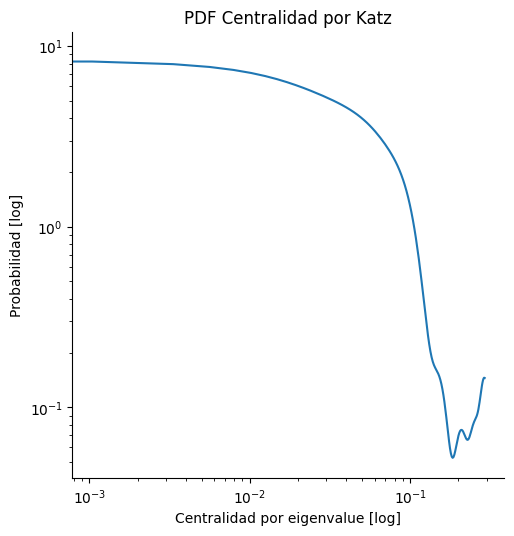

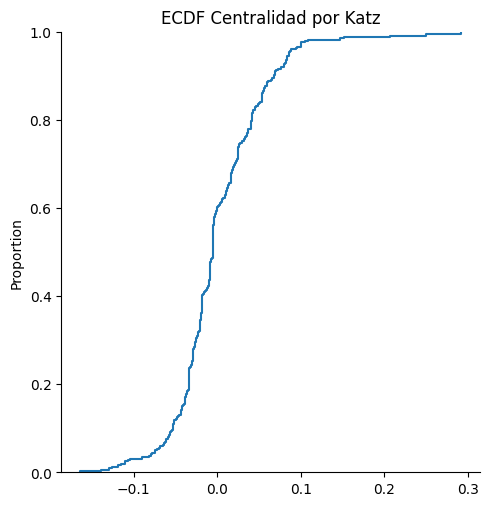

In [62]:
# Kernel density estimation:
def plot_degree_dist(G):
    degrees = list(clustering_coef.values())
    grid = sns.displot(degrees, kind="kde", cut=0)
    grid.set(xscale="log", yscale="log")
    plt.xlabel('Centralidad por eigenvalue [log]')
    plt.ylabel('Probabilidad [log]')
    plt.title('PDF Centralidad por Katz')
    plt.show()

plot_degree_dist(grafo)

# Kernel density estimation:
def plot_degree_dist(G):
    degrees = list(clustering_coef.values())
    sns.displot(degrees, kind="ecdf")
    plt.title('ECDF Centralidad por Katz')
    plt.show()

plot_degree_dist(grafo)

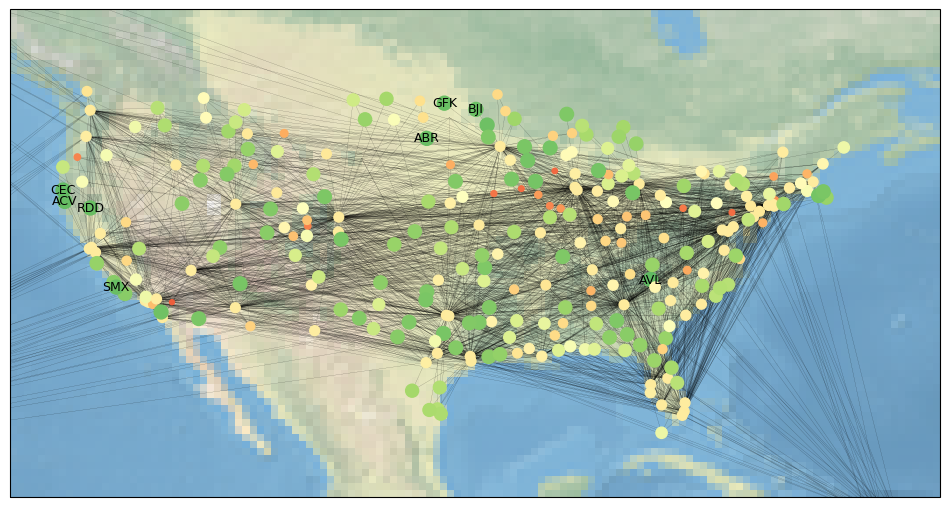

In [63]:
# Definimos el tamaño del nodo con el grado:
coef = nx.katz_centrality_numpy(grafo, weight='DISTANCE')
sizes = [(coef[code]+0.1) * 500 for code in grafo.nodes]

delay = [grafo.nodes[code]['DEPARTURE_DELAY'] for code in grafo.nodes]
labels = {code:code if coef[code] > .1 else '' for code in grafo.nodes}

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(grafo, 
                 ax=ax,
                 font_size=9,
                 alpha=1,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

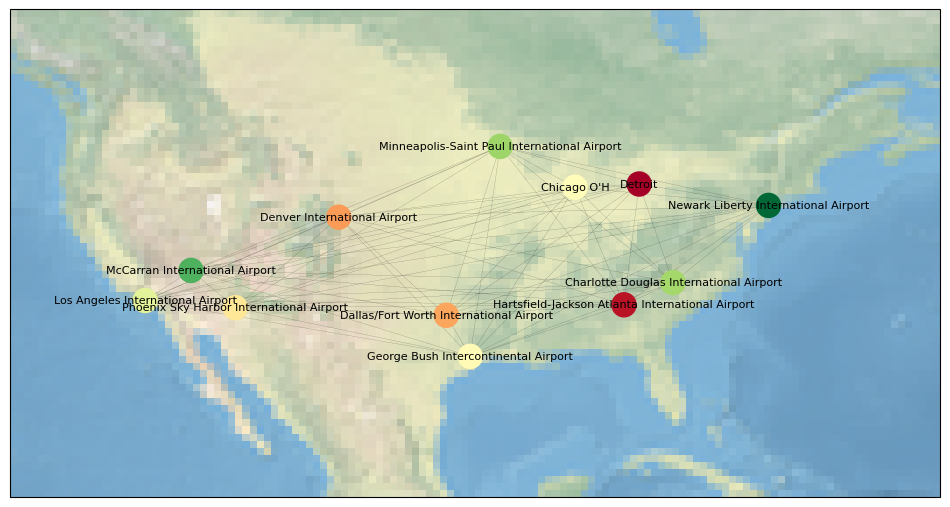

In [64]:
subgrafo = grafo.subgraph(subgrafo)

# Definimos el tamaño del nodo con el grado:
sizes = [(coef[code]+1) * 20 for code in subgrafo.nodes]

delay = [subgrafo.nodes[code]['DEPARTURE_DELAY'] for code in subgrafo.nodes]

# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(subgrafo, 
                 ax=ax,
                 font_size=8,
                 alpha=1,
                 width=.075,
                 node_size=300,
                 labels=labels_subgrafo,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

In [65]:
# draw path in red
# From Boston Logan International Airport (BOS) to Palo Alto Airport (PAO)
path = nx.shortest_path(grafo,source='BOS',target='LAX', method='dijkstra', weight='number_flights')
path_edges = list(zip(path,path[1:]))

In [66]:
labels = {code:grafo.nodes[code]['AIRPORT'] if code in path else '' for code in grafo.nodes}

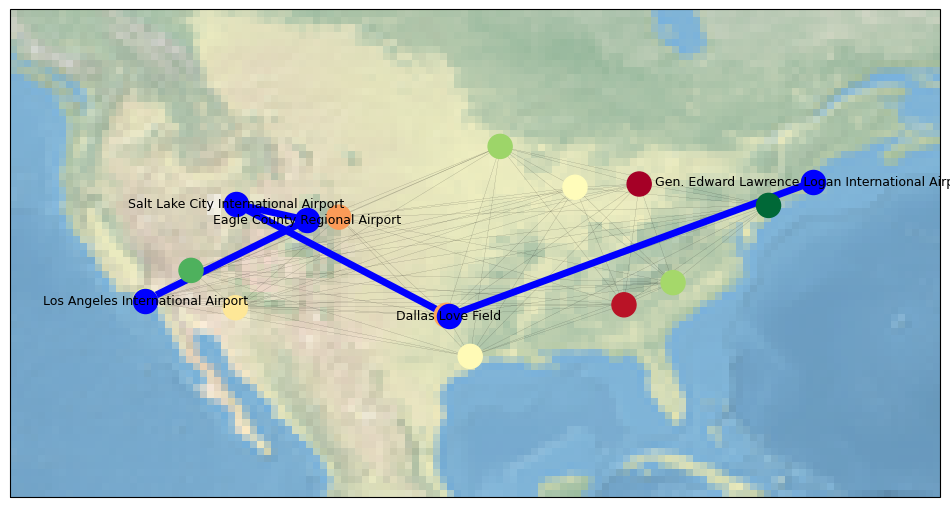

In [67]:
# Map projection
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(12, 8), subplot_kw =dict(projection=crs))

ax.stock_img()
#ax.coastlines()

# Extent of continental US.
ax.set_extent([-128, -62, 20, 50])
nx.draw_networkx(subgrafo, 
                 ax=ax,
                 font_size=9,
                 alpha=1,
                 width=.065,
                 node_size=300,
                 labels=labels,
                 pos=position,
                 node_color=sizes,
                 cmap=plt.cm.RdYlGn)

nx.draw_networkx_nodes(grafo,position,nodelist=path,node_color='b')
nx.draw_networkx_edges(grafo,position,edgelist=path_edges,edge_color='b',width=5)

# Red Neuronal de Grafos (Graph Neural Network)

Node classification

In [68]:
""" Dataset: """

node_features = ['DEPARTURE_DELAY']

dataset = from_networkx(G=grafo, group_node_attrs=node_features, group_edge_attrs=edge_features)
dataset

Data(edge_index=[2, 4628], y=[321], TAXI_OUT=[321], WHEELS_OFF=[321], ELAPSED_TIME=[321], WHEELS_ON=[321], DIVERTED=[321], CANCELLED=[321], AIR_SYSTEM_DELAY=[321], SECURITY_DELAY=[321], AIRLINE_DELAY=[321], LATE_AIRCRAFT_DELAY=[321], WEATHER_DELAY=[321], POSITION=[321, 2], AIRPORT=[321], x=[321, 1], edge_attr=[4628, 3])

In [69]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [70]:
#dataset.x

In [71]:
#transform = T.Compose([T.NormalizeFeatures(['x'])])
dataset.x = torch.from_numpy(normalize(dataset.x.numpy()))

In [72]:
#dataset.x

In [73]:
import torch_geometric.transforms as T

""" Train - Test - Validation split: """
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
dataset = split(dataset)

In [74]:
#dataset.AIRPORT[list(dataset.x).index(0)]

In [75]:
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
        self.conv1 = GATConv(dataset.num_features, 256, heads=6)
        self.lin1 = torch.nn.Linear(dataset.num_features, 6 * 256)
        
        self.norm1 = torch.nn.BatchNorm1d(6 * 256)
    
        self.conv2 = GATConv(6 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(6 * 256, 4 * 256)
        
        self.norm2 = torch.nn.BatchNorm1d(4 * 256)
        
        self.lin3 = torch.nn.Linear(4 * 256, 2 * 256)
        self.lin4 = torch.nn.Linear(2 * 256, 256)
        
        self.out = torch.nn.Linear(256, 1)
        
        # Define proportion or neurons to dropout
        self.dropout = torch.nn.Dropout(0.25)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = F.relu(self.conv1(x, edge_index) + self.lin1(x))
        x = self.norm1(x)
        x = F.relu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.norm2(x)
        x = self.dropout(x)
        x = F.relu(self.lin3(x))
        x = self.dropout(x)
        x = F.relu(self.lin4(x))
        x = self.out(x)
        
        return x

In [76]:
from sklearn.metrics import f1_score

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNN().to(device)
#criterion = torch.nn.CrossEntropyLoss() # Softmax()
criterion = torch.nn.BCEWithLogitsLoss() # Sigmoid()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) #torch.optim.Adam(model.parameters(), lr=0.005)


def train_node_classifier(model, graph, optimizer, criterion, n_epochs=1500):
    losses = []
    val_losses = []
    val_acc = []
    train_acc = []
    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)[graph.train_mask]
        loss = criterion(out, graph.y[graph.train_mask].unsqueeze(1).float())
        
        loss.backward()
        optimizer.step()
        
        # Get predictions 1 or 0:
        pred = (out>0.5).float()
        correct = (pred == graph.y[graph.train_mask]).sum()
        acc = f1_score(graph.y[graph.train_mask].numpy(), pred)
        
        acc_val, val_loss = eval_node_classifier(model, graph, graph.val_mask, criterion)
        
        

        if epoch % 5 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Train Acc: {acc:.3f}, Val Loss: {val_loss:.3f}, Val Acc: {acc_val:.3f}')
        
        losses.append(loss.item())
        val_losses.append(val_loss.item())
        val_acc.append(acc_val)
        train_acc.append(acc)
        
    return model, losses, val_losses, val_acc, train_acc

In [78]:
def eval_node_classifier(model, graph, mask, criterion):
    model.eval()
    # Add sigmoid:
    pred = torch.nn.functional.sigmoid(model(graph))[mask]
    
    val_loss = criterion(model(graph)[mask], graph.y[mask].unsqueeze(1).float())
    
    # Get predictions 1 or 0:
    pred = (pred>0.5).float()
    
    f1 = f1_score(graph.y[mask].unsqueeze(1).float(), pred)

    return f1, val_loss

In [79]:
model, losses, val_losses, val_acc, train_acc  = train_node_classifier(model, dataset, optimizer, criterion, n_epochs=110)

test_acc, _ = eval_node_classifier(model, dataset, dataset.test_mask, criterion)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 005, Train Loss: 0.322, Train Acc: 0.944, Val Loss: 12.650, Val Acc: 0.100
Epoch: 010, Train Loss: 0.091, Train Acc: 0.978, Val Loss: 7.861, Val Acc: 0.273
Epoch: 015, Train Loss: 0.027, Train Acc: 0.996, Val Loss: 0.434, Val Acc: 0.813
Epoch: 020, Train Loss: 0.023, Train Acc: 0.987, Val Loss: 0.148, Val Acc: 0.973
Epoch: 025, Train Loss: 0.029, Train Acc: 0.987, Val Loss: 0.118, Val Acc: 0.973
Epoch: 030, Train Loss: 0.015, Train Acc: 0.991, Val Loss: 0.102, Val Acc: 0.950
Epoch: 035, Train Loss: 0.019, Train Acc: 0.991, Val Loss: 0.135, Val Acc: 0.927
Epoch: 040, Train Loss: 0.027, Train Acc: 0.982, Val Loss: 0.330, Val Acc: 0.950
Epoch: 045, Train Loss: 0.013, Train Acc: 1.000, Val Loss: 0.160, Val Acc: 0.927
Epoch: 050, Train Loss: 0.016, Train Acc: 0.987, Val Loss: 0.146, Val Acc: 0.927
Epoch: 055, Train Loss: 0.019, Train Acc: 0.996, Val Loss: 0.102, Val Acc: 0.950
Epoch: 060, Train Loss: 0.041, Train Acc: 0.978, Val Loss: 0.120, Val Acc: 0.927
Epoch: 065, Train Loss: 0.0

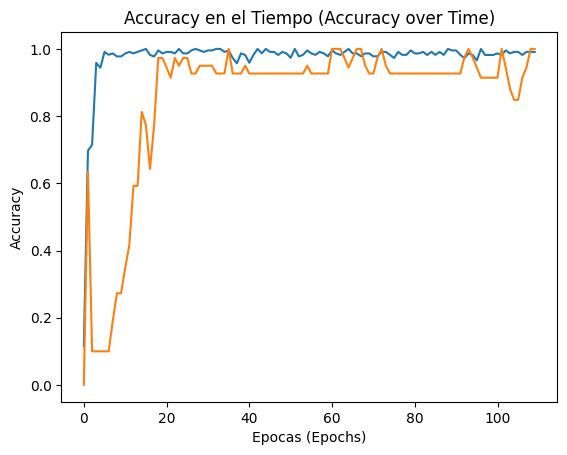

In [80]:
# Visualize learning (accuracy)
loss_indices = [i for i,l in enumerate(train_acc)] 
sns.lineplot(x=loss_indices, y=train_acc, legend='auto')
sns.lineplot(x=loss_indices, y=val_acc, legend='auto')
plt.title('Accuracy en el Tiempo (Accuracy over Time)')
plt.xlabel('Epocas (Epochs)')
plt.ylabel('Accuracy')
plt.show()

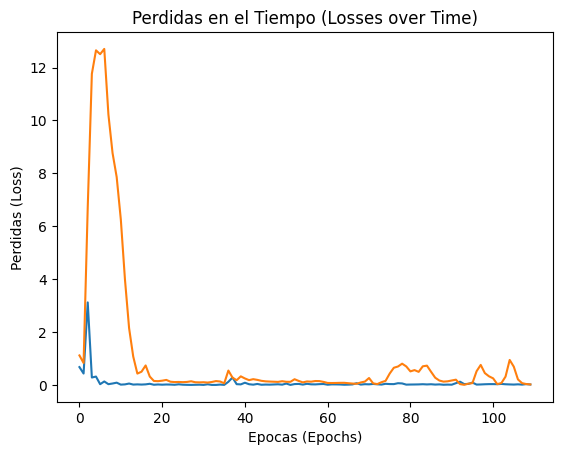

In [81]:
# Visualize learning (training loss)
loss_indices = [i for i,l in enumerate(losses)] 
sns.lineplot(x=loss_indices, y=losses, legend='auto')
sns.lineplot(x=loss_indices, y=val_losses, legend='auto')
plt.title('Perdidas en el Tiempo (Losses over Time)')
plt.xlabel('Epocas (Epochs)')
plt.ylabel('Perdidas (Loss)')
plt.show()

### Mostrar las Predicciones (Plot predictions)

In [82]:
# Para solo un batch (just one batch)
with torch.no_grad():
    dataset.to(device)
    # Add sigmoid:
    pred = torch.nn.functional.sigmoid(model(dataset))[dataset.test_mask]
    # Get predictions 1 or 0:
    pred = (pred>0.5).float()

In [83]:
y_true = dataset.y[dataset.test_mask].numpy()
y_true.shape

(64,)

In [84]:
y_pred = pred.numpy()
y_pred.shape

(64, 1)

In [85]:
#pred

### Matriz de confusión (Confusion Matrix) 

In [86]:
matriz_confusion = multilabel_confusion_matrix(y_true, pred)
print(matriz_confusion)

[[[35  1]
  [ 0 28]]

 [[28  0]
  [ 1 35]]]


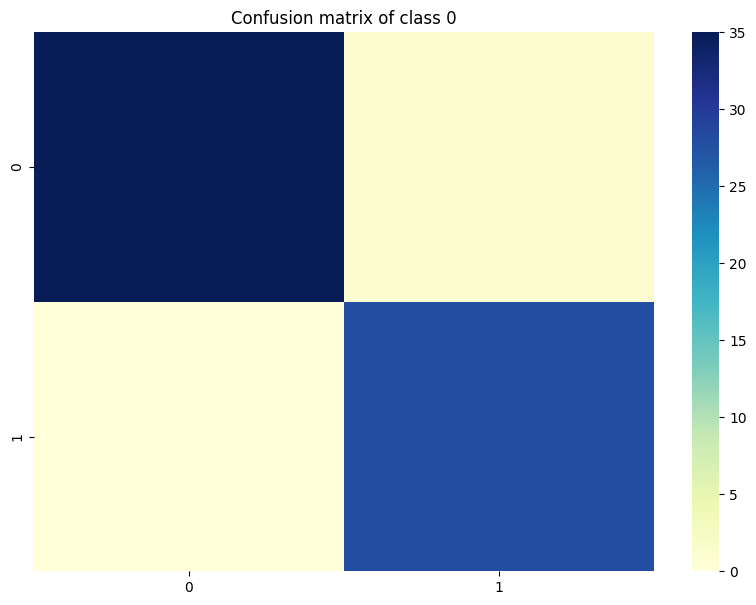

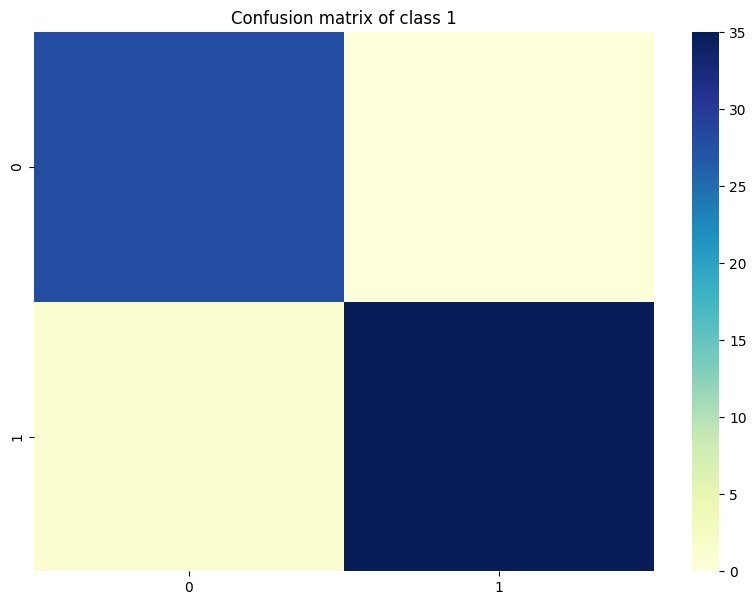

In [87]:
for class_i in range(len(matriz_confusion)):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    sns.heatmap(matriz_confusion[class_i], cmap="YlGnBu", fmt='', ax=ax)
    plt.title(f'Confusion matrix of class {class_i}')